/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  1 / 100: ksone
  2 / 100: kstwobign
  3 / 100: norm
  4 / 100: alpha
  5 / 100: anglit
  6 / 100: arcsine
  7 / 100: beta
  8 / 100: betaprime
  9 / 100: bradford
 10 / 100: burr
 11 / 100: burr12
 12 / 100: fisk
 13 / 100: cauchy
 14 / 100: chi
 15 / 100: chi2
 16 / 100: cosine
 17 / 100: dgamma
 18 / 100: dweibull
 19 / 100: expon
 20 / 100: exponnorm
 21 / 100: exponweib
 22 / 100: exponpow
 23 / 100: fatiguelife
 24 / 100: foldcauchy
 25 / 100: f
 26 / 100: foldnorm
 27 / 100: weibull_min
 28 / 100: weibull_max
 29 / 100: frechet_r
 30 / 100: frechet_l
 31 / 100: genlogistic
 32 / 100: genpareto
 33 / 100: genexpon
 34 / 100: genextreme
 35 / 100: gamma
 36 / 100: erlang
 37 / 100: gengamma
 38 / 100: genhalflogistic
 39 / 100: gompertz
 40 / 100: gumbel_r
 41 / 100: gumbel_l
 42 / 100: halfcauchy
 43 / 100: halflogistic
 44 / 100: halfnorm
 45 / 100: hypsecant
 46 / 100: gausshyper
 47 / 100: invgamma
 48 / 100: invgauss
 49 / 100: geninvgauss
 50 / 100: norminvgauss
 51 / 100: 

Text(0, 0.5, 'Frequency')

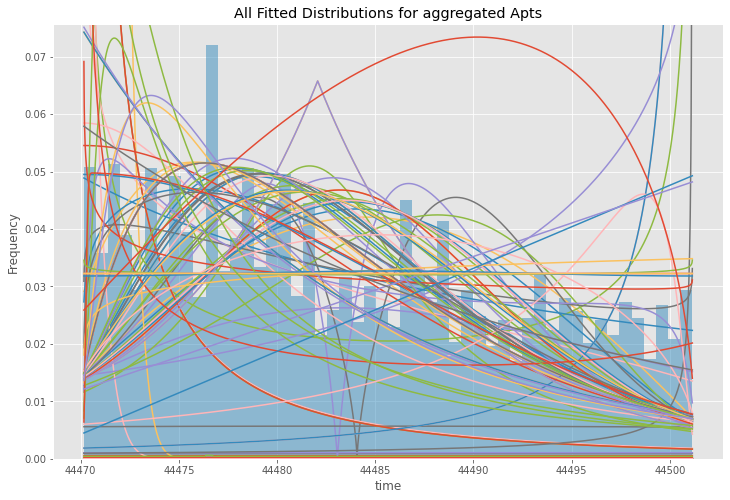

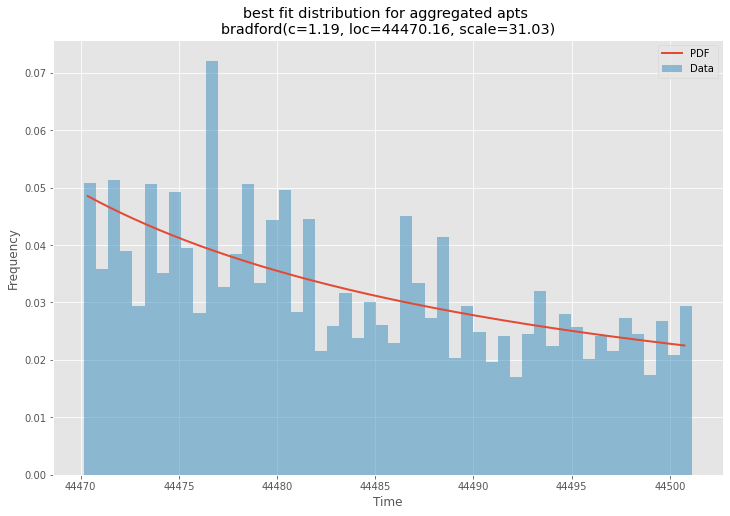

In [ ]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

apt_all = pd.read_csv('/content/combined-csv-files.csv')

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=2000, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(apt_all.values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 2000, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'All Fitted Distributions for aggregated Apts')
ax.set_xlabel(u'time')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'best fit distribution for aggregated apts \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')